## Business use case:
+ An FMCG company entered into the instant noodles business two years back. Their higher management has noticed that there is a miss match in the demand and supply. Where the demand is high, supply is pretty low and where the demand is low, supply is pretty high. In both ways, it is an inventory cost loss to the company; hence, the higher management wants to optimize the supply quantity in every warehouse in the entire country.


### Goal & Objective: 
+ To build a model that will determine the optimum weight of the product to be shipped each time to the warehouse.
+ Also, to analyze the demand pattern in different pockets of the country so management can drive the advertisement campaign, particularly in those pockets.



In [126]:
#importing libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
%matplotlib inline

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

In [127]:
#!pip install termcolor
import colorama
from colorama import Fore, Style  # makes strings colored
from termcolor import colored
from termcolor import cprint

# Figure&Display options
plt.rcParams["figure.figsize"] = (16, 9)
pd.set_option('max_colwidth',200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 200)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [128]:
#!pip install cufflinks

In [129]:
# Importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [130]:
fmcg_data = pd.read_csv("Data.csv")
fmcg_data.head()

,Ware_house_ID,WH_Manager_ID,Location_type,WH_capacity_size,zone,WH_regional_zone,num_refill_req_l3m,transport_issue_l1y,Competitor_in_mkt,retail_shop_num,wh_owner_type,distributor_num,flood_impacted,flood_proof,electric_supply,dist_from_hub,workers_num,wh_est_year,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m,product_wg_ton
0,WH_100000,EID_50000,Urban,Small,West,Zone 6,3,1,2,4651,Rented,24,0,1,1,91,29.0,NaN,13,0,A,5,15,17115
1,WH_100001,EID_50001,Rural,Large,North,Zone 5,0,0,4,6217,Company Owned,47,0,0,1,210,31.0,NaN,4,0,A,3,17,5074
2,WH_100002,EID_50002,Rural,Mid,South,Zone 2,1,0,4,4306,Company Owned,64,0,0,0,161,37.0,NaN,17,0,A,6,22,23137
3,WH_100003,EID_50003,Rural,Mid,North,Zone 3,7,4,2,6000,Rented,50,0,0,0,103,21.0,NaN,17,1,A+,3,27,22115
4,WH_100004,EID_50004,Rural,Large,North,Zone 5,3,1,2,4740,Company Owned,42,1,0,1,112,25.0,2009.0,18,0,C,6,24,24071


In [131]:
#!pip install ipywidgets

In [132]:
def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.shape[0]).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

In [133]:
def first_looking(df):
    print(colored("Shape:", attrs=['bold']), df.shape,'\n', 
          colored('*'*100, 'red', attrs=['bold']),
          colored("\nInfo:\n", attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", attrs=['bold']), df.nunique(),'\n',
          colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Missing Values:\n", attrs=['bold']), missing_values(df),'\n', 
          colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", attrs=['bold']), list(df.columns),'\n', 
          colored('*'*100, 'red', attrs=['bold']), sep='')

    df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')
    print(colored("Columns after rename:", attrs=['bold']), list(df.columns),'\n',
          colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Descriptive Statistics \n", attrs=['bold']), df.describe().round(2),'\n',
          colored('*'*100, 'red', attrs=['bold']), sep='') # Gives a statstical breakdown of the data.
    print(colored("Descriptive Statistics (Categorical Columns) \n", attrs=['bold']), df.describe(include=object).T,'\n',
          colored('*'*100, 'red', attrs=['bold']), sep='') # Gives a statstical breakdown of the data.

In [134]:
# To view summary information about the columns

def first_look(df,col):
    print("column name    : ", col)
    print("per_of_nulls   : ", "%", round(df[col].isnull().sum()/df.shape[0]*100, 2))
    print("num_of_nulls   : ", df[col].isnull().sum())
    print("num_of_uniques : ", df[col].nunique())
    print("Value counts   : \n", df[col].value_counts(dropna = False)) 
    print(colored("-"*100, 'red',attrs=['bold']), sep="")

In [135]:
def multicolinearity_control(df):
    feature =[]
    collinear=[]
    for col in df.corr().columns:
        for i in df.corr().index:
            if (abs(df.corr()[col][i])> .75 and abs(df.corr()[col][i]) < 1):
                    feature.append(col)
                    collinear.append(i)
                    print(colored(f"Multicolinearity alert in between:{col} - {i}", 
                                  "red", attrs=['bold']), df.shape,'\n',
                                  colored('*'*100, 'red', attrs=['bold']), sep='')
    else:
        print("No Multicolinearity")

In [136]:
def duplicate_values(df):
    print(colored("Duplicate check...", attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored(" Duplicates were dropped!"),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There are no duplicates"),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')

In [137]:
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('We will now check the missing values and if necessary, the realted columns will be dropped!', attrs=['bold']),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')

In [138]:
def drop_null(df, limit):
    print('Shape:', df.shape)
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'null and were dropped')
            df.drop(i, axis=1, inplace=True)
            print('new shape:', df.shape)       
    print(colored("New shape after missing value control:"),'\n', df.shape)

In [139]:
missing_values(fmcg_data)

,Missing_Number,Missing_Percent
wh_est_year,11881,0.47524
workers_num,990,0.03960
approved_wh_govt_certificate,908,0.03632


In [140]:
first_looking(fmcg_data)

Shape:(25000, 24)
****************************************************************************************************
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Ware_house_ID                 25000 non-null  object 
 1   WH_Manager_ID                 25000 non-null  object 
 2   Location_type                 25000 non-null  object 
 3   WH_capacity_size              25000 non-null  object 
 4   zone                          25000 non-null  object 
 5   WH_regional_zone              25000 non-null  object 
 6   num_refill_req_l3m            25000 non-null  int64  
 7   transport_issue_l1y           25000 non-null  int64  
 8   Competitor_in_mkt             25000 non-null  int64  
 9   retail_shop_num               25000 non-null  int64  
 10  wh_owner_type                 25000 non-null  object

In [141]:
duplicate_values(fmcg_data)

Duplicate check...
There are no duplicates
****************************************************************************************************


### Checking for null values and dropping the columns with more than 30% null

<Figure size 500x500 with 0 Axes>

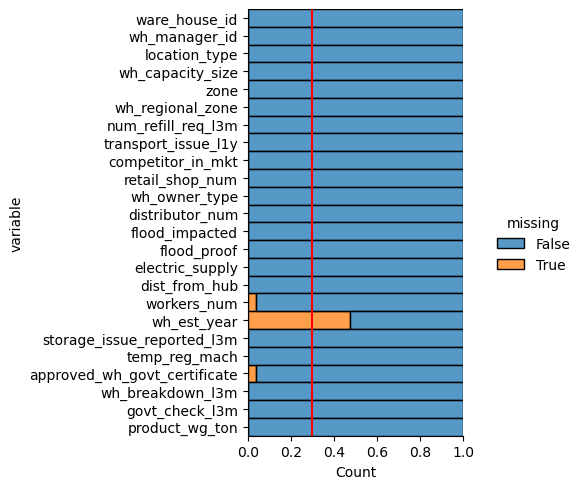

In [142]:
plt.figure(figsize = (5, 5))

sns.displot(
    data = fmcg_data.isnull().melt(value_name = "missing"),
    y = "variable",
    hue = "missing",
    multiple = "fill",
    height = 5)

plt.axvline(0.3, color = "r");

In [143]:
drop_null(fmcg_data,30)

Shape: (25000, 24)
11881 percent of wh_est_year null and were dropped
new shape: (25000, 23)
New shape after missing value control: 
 (25000, 23)


In [144]:
multicolinearity_control(fmcg_data)

Multicolinearity alert in between:storage_issue_reported_l3m - product_wg_ton(25000, 23)
****************************************************************************************************
Multicolinearity alert in between:product_wg_ton - storage_issue_reported_l3m(25000, 23)
****************************************************************************************************
No Multicolinearity


# Building a Pipeline and saving the model

In [145]:
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

In [146]:
drop_cols = ["ware_house_id", "wh_manager_id"]
df=fmcg_data.drop(columns=drop_cols)

In [147]:
X = df.drop(columns="product_wg_ton", axis=1)
y = df["product_wg_ton"]

In [148]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.33, random_state=42)

In [149]:
X_train

,location_type,wh_capacity_size,zone,wh_regional_zone,num_refill_req_l3m,transport_issue_l1y,competitor_in_mkt,retail_shop_num,wh_owner_type,distributor_num,flood_impacted,flood_proof,electric_supply,dist_from_hub,workers_num,storage_issue_reported_l3m,temp_reg_mach,approved_wh_govt_certificate,wh_breakdown_l3m,govt_check_l3m
12131,Urban,Mid,South,Zone 4,3,0,3,5890,Rented,46,0,0,0,223,38.0,24,1,A+,2,26
12827,Rural,Small,North,Zone 6,8,0,2,5483,Rented,17,0,0,0,150,NaN,5,0,A,4,9
2912,Rural,Large,West,Zone 6,8,0,4,7774,Company Owned,22,0,0,1,210,27.0,20,0,B+,6,6
13762,Rural,Large,North,Zone 5,6,3,3,4685,Company Owned,18,1,0,1,196,30.0,15,0,B+,6,24
6369,Rural,Mid,West,Zone 4,5,0,4,4691,Rented,23,0,0,1,179,31.0,5,1,A,2,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21575,Rural,Mid,West,Zone 3,6,0,4,4362,Company Owned,49,0,0,1,56,25.0,19,0,A,1,19
5390,Rural,Large,North,Zone 5,0,1,4,6983,Company Owned,23,0,0,1,228,26.0,16,0,A+,3,14
860,Urban,Mid,North,Zone 4,7,1,3,4818,Rented,22,0,0,0,187,24.0,20,0,C,2,26
15795,Rural,Mid,North,Zone 3,1,0,2,4909,Company Owned,62,0,0,1,227,26.0,19,0,B,2,27


In [150]:
x_train=X_train.copy()

In [151]:

# The ColumnsSelector class inherits from the sklearn.base classes 
# (BaseEstimator, TransformerMixin). This makes it compatible with 
# scikit-learn’s Pipelines
class MappingColumns(BaseEstimator, TransformerMixin):
    # initializer 
    def __init__(self,):
        pass
        
    def fit(self, X, y = None):
        return self
    
    def locationType(self,x):
        if x=="Urban":
            return 0
        if x=="Rural":
            return 1

    def whCapacity(self,x):
        if x == "Small":
            return 0
        if x == "Mid":
            return 1
        if x == "Large":
            return 2

    def whOwner(self,x):
        if x == "Rented":
            return 0
        if x == "Company Owned":
            return 1

    def appGovtCert(self,x):
        if x  == "C":
            return 0
        if x == "B":
            return 1
        if x == "B+":
            return 2
        if x == "A":
            return 3
        if x == "A+":
            return 4



    def transform(self, X, y = None):
        X["location_type"] = X["location_type"].apply(self.locationType)
        X["wh_capacity_size"]=X["wh_capacity_size"].apply(self.whCapacity)
        X["wh_owner_type"]=X["wh_owner_type"].apply(self.whOwner)
        X["approved_wh_govt_certificate"]=X["approved_wh_govt_certificate"].apply(self.appGovtCert)
        return X

In [152]:
mapping = Pipeline(steps=[("map_col",MappingColumns())])
col_encode=['zone', 'wh_regional_zone']
preprocessor = ColumnTransformer(transformers=[('ohe', OneHotEncoder(sparse=False, drop='first',handle_unknown='ignore'), col_encode)], remainder='passthrough')
KNN_transformer = Pipeline(steps=[("robust_scalar" , RobustScaler(with_centering=False)),("imputer" , KNNImputer(n_neighbors=5, weights='distance'))])
pipeline = Pipeline(steps=[
    ('mapping', mapping),
    ('preprocessor', preprocessor),
    ('KNN_transformer',KNN_transformer),
    ])

In [153]:
X_final=pipeline.fit_transform(x_train)
X_test = pipeline.transform(X_test)

### Model Building and Evaluation

In [154]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [155]:
# !pip install xgboost

### Initialize Default Models in a dictionary

In [167]:
GBmodel = GradientBoostingRegressor()
GBmodel.fit(X_final, y_train) # Train model
# Make predictions
y_train_pred = model.predict(X_final)
y_test_pred = model.predict(X_test)

#train
rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
r_score_train = r2_score(y_train, y_train_pred)

#test
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
r_score_test = r2_score(y_test, y_test_pred)
print(f"Root mean square train error: {rmse_train}\nRoot mean square test error: {rmse_test}\nTrain score: {r_score_train}\nTest score: {r_score_test}\n")

Root mean square train error: 915.8558047085133
Root mean square test error: 947.6469965945621
Train score: 0.993775264994734
Test score: 0.9933330707894896



In [169]:
import joblib
data = {"model": GBmodel, "pipeline":pipeline}
with open ('saved_steps.pkl', 'wb') as file:
    joblib.dump(data, file)

In [170]:
with open ("saved_steps.pkl", "rb") as file:
    joblib.load(file)

In [173]:
pipe = data["pipeline"]